# Laboratory #3_2 : Image Classification using Bag of Visual Words

At the end of this laboratory, you would get familiarized with

*   Creating Bag of Visual Words
    *   Feature Extraction
    *   Codebook construction
    *   Classification

**Remember this is a graded exercise.**

*   For every plot, make sure you provide appropriate titles, axis labels, legends, wherever applicable.
*   Create reusable functions where ever possible, so that the code could be reused at different places.
*   Mount your drive to access the images.
*   Add sufficient comments and explanations wherever necessary.

---

In [68]:
# from google.colab import drive
# drive.mount('/content/drive')

In [69]:
# Loading necessary libraries (Feel free to add new libraries if you need for any computation)

import os
import numpy as np

from skimage.feature import ORB
from skimage.color import rgb2gray
from skimage.io import imread
from scipy.cluster.vq import vq

from matplotlib import pyplot as plt

## Loading dataset

We will use 3 categories from Caltech 101 objects dataset for this experiment. Upload the dataset to the drive and mount it.

In [70]:
# modify the dataset variable with the path from your drive

dataset_path = r'CV/Labs/P07_1_bag_of_words/Caltech_101_subset'

In [71]:
categories = ['butterfly', 'kangaroo', 'dalmatian']
ncl = len(categories) * 10

*   Create a list of file and the corresponding labels

In [72]:
# solution
data = []
for category in os.listdir(dataset_path):
    for file in os.listdir(os.path.join(dataset_path, category)):
        img = imread(os.path.join(dataset_path, category, file))
        if len(img.shape) == 3:
            img = rgb2gray(img, channel_axis=2)
        num_cat = categories.index(category)
        data.append([img, num_cat])

print(data[0][0].shape)
print(data[0][1])

(196, 300)
2


In [73]:
print('Total number of images:', len(data))

Total number of images: 244


*   Create a train / test split where the test is 10% of the total data

In [74]:
# solution

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split([x[0] for x in data], 
                                                    [x[1] for x in data], 
                                                    test_size=0.1, 
                                                    random_state=42, 
                                                    stratify=[x[1] for x in data])

In [75]:
print('Train set:', len(x_train))
print('Test set:', len(x_test))

Train set: 219
Test set: 25


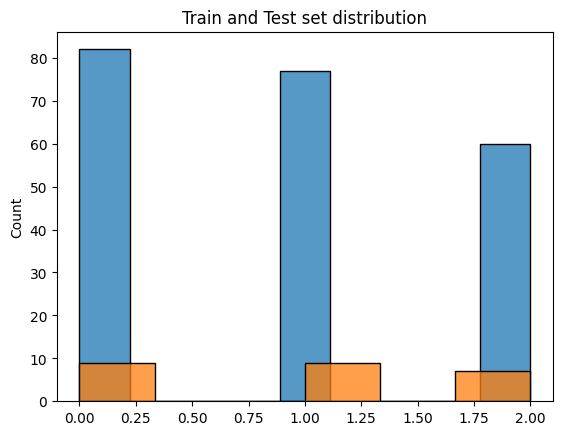

In [76]:
import seaborn as sns
sns.histplot(y_train)
sns.histplot(y_test)
plt.title('Train and Test set distribution')
plt.show()

*   How do you select the train/test split?

**Solution**

As it can be infered from the previous plot, train and test are selected so that test set has the same distribution over the classes as the train set, so that the difference betweeen the train and test set is not due to the difference in the distribution of the classes but to our model and parameters selection_.

## Feature Extraction using ORB

The first step is to extract descriptors for each image in our dataset. We will use ORB to extract descriptors.

*   Create ORB detector with 64 keypoints.


In [77]:
# solution

descriptor_extractor = ORB(n_keypoints=64)

*   Extract ORB descriptors from all the images in the train set.


In [81]:
# solution

def extract_features(img, descriptor_extractor):
    descriptor_extractor.detect_and_extract(img)
    return descriptor_extractor.keypoints, descriptor_extractor.descriptors

ls_desc = []
for img in [x[0] for x in data]:
    _, desc = extract_features(img, descriptor_extractor)
    ls_desc.append(desc)

*   What is the size of the feature descriptors? What does each dimension represent in the feature descriptors?

In [82]:
# solution

print("Dimensions of feature descriptors: ", set([x.shape for x in ls_desc]))


Dimensions of feature descriptors:  {(64, 256)}


**Solution**

The size of the feature descriptors generated by ORB is fixed and typically 256 bits (32 bytes) per descriptor. Each dimension of the feature descriptor represents a binary value (0 or 1) generated by the BRIEF (Binary Robust Independent Elementary Features) algorithm, which is used by ORB for descriptor computation.

To break it down:

- Size of Feature Descriptor: 256 bits (32 bytes)

- Each Dimension: Represents a binary value (0 or 1) indicating the result of a binary test applied during the BRIEF algorithm.

The result of the BRIEF algorithm is this binary vector, which serves as a compact representation of the local image characteristics around a keypoint. This binary nature makes BRIEF descriptors computationally efficient and suitable for applications where speed and memory are critical, such as real-time computer vision tasks. The binary descriptors can be used for matching keypoints between images by comparing the Hamming distance between their binary vectors.

## Codebook Construction

Codewords are nothing but vector representation of similar patches. This codeword produces a codebook similar to a word dictionary. We will create the codebook using K-Means algorithm

*   Create a codebook using K-Means with k=number_of_classes*10
*   Hint: Use sklearn.cluster.MiniBatchKMeans for K-Means

In [87]:
# Firs of all let's concatenate all the descriptors in a single array
X_desc = np.concatenate(ls_desc)
print("The length should be ", len(ls_desc), " images x", 64, " features:", len(ls_desc) * 64)
print("Shape of the concatenated array: ", X_desc.shape)

The length should be  244  images x 64  features: 15616
Shape of the concatenated array:  (15616, 256)


In [88]:
# solution
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=ncl, random_state=42)
kmeans.fit(X_desc)

/home/alberto/Documentos/GitHub/UPC_MasterArtificialIntelligence/.venv/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


MiniBatchKMeans(n_clusters=30, random_state=42)

*   Create a histogram using the cluster centers for each image descriptor.
    *   Remember the histogram would be of size *n_images x n_clusters*.

In [97]:
# Use kmeans to predict the cluster for each descriptor
cluster_assignments = kmeans.predict(X_desc)

# Calculate histograms for each image
histograms = []
start_idx = 0
for descriptors in X_desc:
    num_descriptors = len(descriptors)
    image_assignments = cluster_assignments[start_idx:start_idx + num_descriptors]
    histogram, _ = np.histogram(image_assignments, bins=ncl, range=[0, ncl])
    histograms.append(histogram)
    start_idx += num_descriptors

# Convert the histograms to a numpy array
histograms_array = np.array(histograms)

In [98]:
print(histograms_array.shape)

(15616, 30)


In [92]:
codebook

array([[0.42775468, 0.27286902, 0.7016632 , ..., 0.66632017, 0.55093555,
        0.41112266],
       [0.30784708, 0.23474178, 0.37290409, ..., 0.68008048, 0.51509054,
        0.6934943 ],
       [0.31524441, 0.509942  , 0.23736537, ..., 0.56255178, 0.38898094,
        0.70091135],
       ...,
       [0.36877395, 0.77777778, 0.51676245, ..., 0.40086207, 0.67863985,
        0.32806513],
       [0.48784799, 0.77728679, 0.41272647, ..., 0.37914273, 0.7613787 ,
        0.60980999],
       [0.57734531, 0.17165669, 0.55638723, ..., 0.65768463, 0.46357285,
        0.60928144]])


# Creating Classification Model

*   The next step is to create a classification model. We will use a C-Support Vector Classification for creating the model.



In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

*   Use GridSearchCV to find the optimal value of C and Gamma.

In [54]:
# solution



# Testing the Classification Model

*   Extract descriptors using ORB for the test split
*   Use the previously trained k-means to generate the histogram
*   Use the classifier to predict the label


In [55]:
# solution



*   Calculate the accuracy score for the classification model

In [56]:
# solution



*   Generate the confusion matrix for the classification model

In [57]:
# solution



*   Why do we use Clustering to create the codebook? 
*   What are the other techniques that can be used to create the codebook?

**Solution**

*(Double-click or enter to edit)*

...

# Increased Feature Dimensions

*   Repeat the classification using features of 256 ORB keypoints.

In [58]:
# solution



*   What is the difference in classifier performance between using 64 keypoints and 256 keypoints?

**Solution**

*(Double-click or enter to edit)*

...

*   Will further adding more keypoints increase the performance of the algorithm?

**Solution**

*(Double-click or enter to edit)*

...